In [0]:
import json
import numpy as np

# load metadata
with open("train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

In [0]:
import torch
import torch.nn as nn
import numpy as np
import random


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output


In [3]:
def preprocess_articles():
    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer

    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):

        if id % 500 == 0:
            print("Claims preprocessed: ", id)

        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)

        # measure similarity between claim and each sentence
        similarity = X[-1, :] @ np.transpose(X[:-2, :])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1, min(5, sorted_index.shape[1]) + 1):
            top_sentences.append(sentences[sorted_index[0, -i]])
        relevant_sentences.append(top_sentences)

    return metadata, relevant_sentences


metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim

In [4]:
from bpemb import BPEmb

n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)


def sampleClaim(metadata, model):
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    
    if model == 'ii':
      claimant = metadata[id]["claimant"]
      claim += ' '+ claimant
      
    if model == 'iii':
      claimant = metadata[id]["claimant"]
      claim += ' '+ claimant
      for sentence in relevant_sentences[id]:
        claim += ' '+ sentence
        
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding, (embedding.shape[0], 1, embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# !pip install bpemb

In [0]:
# ! unzip '/content/drive/My Drive/train.zip'

In [0]:
def train(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn(line_tensor[i], hidden)
    output = classifier(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()

    return output, loss.item()

In [0]:
import time
import math

n_hidden = 128
n_categories = 3
rnn = RNN(n_embedding_dims, n_hidden)
classifier = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [0]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def iterTrain(model):
  start = time.time()

  train_data = metadata[:10000]
  test_data = metadata[10000:]
  train_cumulative_loss = 0
  test_cumulative_loss = 0
  average_train_accuracy = 0
  average_test_accuracy = 0
  all_train_losses = []
  all_train_accuracies = []
  all_test_losses = []
  all_test_accuracies = []
  count = 0
  
  for iter in range(1, n_iters + 1):
      train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data, model)
      train_output, train_loss = train(train_category_tensor, train_line_tensor)
      top_train_value, top_train_index = train_output.topk(1)
      train_guess_category = top_train_index[0].item()
      train_cumulative_loss += train_loss
      train_accuracy = 1 if train_guess_category == train_category else 0
      average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count + 1)

      test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data, model)
      test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
      top_test_value, top_test_index = test_output.topk(1)
      test_guess_category = top_test_index[0].item()
      test_cumulative_loss += test_loss
      test_accuracy = 1 if test_guess_category == test_category else 0
      average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count + 1)
      count += 1

      # Add current loss avg to list of losses
      if iter % plot_every == 0:
          train_correct = 'âœ“' if train_guess_category == train_category else 'âœ— (%s)' % train_category
          print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (
          iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every,
          train_line, train_guess_category, train_correct))
          test_correct = 'âœ“' if test_guess_category == test_category else 'âœ— (%s)' % test_category
          print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (
          iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every,
          test_line, test_guess_category, test_correct))
          all_train_losses.append(train_cumulative_loss / plot_every)
          all_train_accuracies.append(average_train_accuracy)
          all_test_losses.append(test_cumulative_loss / plot_every)
          all_test_accuracies.append(average_test_accuracy)
          train_cumulative_loss = 0
          average_train_accuracy = 0
          test_cumulative_loss = 0
          average_test_accuracy = 0
          count = 0
  return all_train_accuracies, all_test_accuracies

Train: 1000  1% (0m 4s) average_accuracy=0.5330 average_loss=0.9738 "In last week’s debate, Bernie questioned Hillary’s commitment to fighting climate change because a whopping 0.2 percent of the money given to our campaign has come from employees of oil and gas companies. Not even 2 percent, mind you: 0.2 percent." / 1 âœ“
Test: 1000  1% (0m 4s) average_accuracy=0.4940 average_loss=0.9711 "Someone can write an article or book, totally make up stories and form a picture of a person that is literally the exact opposite of the fact, and get away with it without retribution or cost. Don’t know why Washington politicians don’t change libel laws?" / 1 âœ— (0)
Train: 2000  2% (0m 9s) average_accuracy=0.5370 average_loss=0.9233 The Obama administration secretly bribed Iran to release four prisoners in January 2016.

				
					

						See Example(s)

						
							
								
									Did US Bribe Iran To Release Americans? $400 Million, Report Says
http://www.ibtimes.com/did-us-bribe-iran-relea

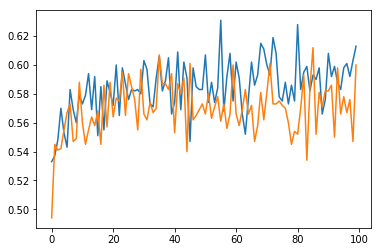

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

all_i_train_accuracies, all_i_test_accuracies = iterTrain('i')
plt.figure()
plt.plot(all_i_train_accuracies)
plt.plot(all_i_test_accuracies)

Train: 1000  1% (0m 5s) average_accuracy=0.5610 average_loss=0.9114 "But we create a lot of jobs, 500,000 jobs as of two months ago, and plenty created since. … As an example, Ford, General Motors." Donald Trump / 0 âœ“
Test: 1000  1% (0m 5s) average_accuracy=0.5460 average_loss=0.9406 Wegmans is offering a coupon for $200 off a purchase to Facebook users who complete a short series of steps.

				
					

						See Example(s)

						
							
								
																												Collected via Facebook, February 2016  / 0 âœ“
Train: 2000  2% (0m 9s) average_accuracy=0.6420 average_loss=0.8340 "You've got a medical report on me that meets the same standard as Mitt Romney and Barack Obama." Hillary Clinton / 1 âœ“
Test: 2000  2% (0m 9s) average_accuracy=0.5730 average_loss=0.9219 "Incredibly, some Tallahassee politicians want to make Florida a sanctuary state." Richard Corcoran / 1 âœ“
Train: 3000  3% (0m 14s) average_accuracy=0.6170 average_loss=0.8551 Lil' Wayne announced that he was dia

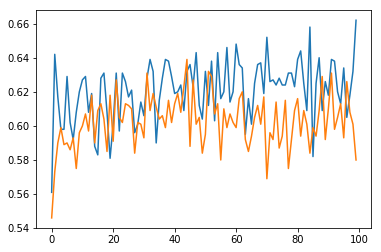

In [14]:
all_ii_train_accuracies, all_ii_test_accuracies = iterTrain('ii')
plt.figure()
plt.plot(all_ii_train_accuracies)
plt.plot(all_ii_test_accuracies)

Train: 1000  1% (0m 27s) average_accuracy=0.5090 average_loss=0.9615 The question of Almajiris’ lack of primary or basic education are all local government problems. President Muhammadu Buhari Primary homelessness or rooflessness includes people living in streets or without any shelter. You all are champions. The Petroleum Act of 1969 is the primary legislation governing petroleum activities in Nigeria. “It is therefore surprising and show of lack of spirit of sportsmanship for SDP to claim to have pulled out of a process that they fully participated and concluded successfully. The Federal Government, the states and local governments shared N409.354 billion from the Federation Account for the month of May. / 0 âœ— (1)
Test: 1000  1% (0m 27s) average_accuracy=0.4590 average_loss=1.0286 In February, John McCain "suggested" the Bergdahl-Taliban swap that he now calls "outrageous and dangerous." Rachel Maddow Sayles Belton, born and raised in St. Paul, was the first woman, and first Africa

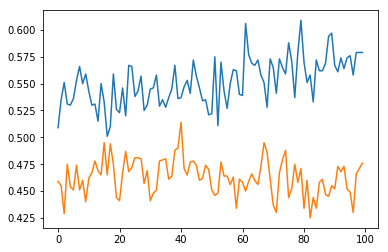

In [15]:
all_iii_train_accuracies, all_iii_test_accuracies = iterTrain('iii')
plt.figure()
plt.plot(all_iii_train_accuracies)
plt.plot(all_iii_test_accuracies)

<Figure size 432x288 with 0 Axes>

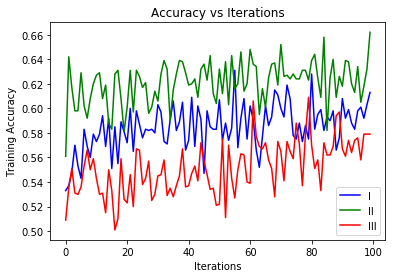

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(all_i_train_accuracies,'b',label='I')
plt.plot(all_ii_train_accuracies,'g',label='II')
plt.plot(all_iii_train_accuracies,'r',label='III')


plt.title('Accuracy vs Iterations')
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend()
plt.savefig("part_2_A_training_graph.png")
plt.figure()

<Figure size 432x288 with 0 Axes>

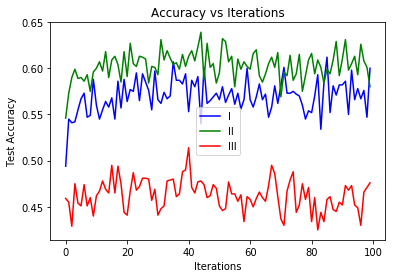

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(all_i_test_accuracies,'b',label='I')
plt.plot(all_ii_test_accuracies,'g',label='II')
plt.plot(all_iii_test_accuracies,'r',label='III')


plt.title('Accuracy vs Iterations')
plt.xlabel("Iterations")
plt.ylabel("Test Accuracy")
plt.legend()
plt.savefig("part_2_A_test_graph.png")
plt.figure()